<a href="https://colab.research.google.com/github/AgniKoko/DIP_HW02/blob/main/DIP_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Κοκορότσικου Αγνή Ιωάννα, 58767
[GitHub repository](https://github.com/AgniKoko/DIP_HW02)

# Εργαστηριο

**Άσκηση 5 - Τεχνικές Συμπίεσης εικόνας**

Χρήσιμες Βιβλιοθήκες:
* Documentation OpenCV:      https://docs.opencv.org/4.x/index.html
* Documentation SciPy:       https://docs.scipy.org/doc/scipy/
* Documentation skimage:     https://scikit-image.org/docs/stable/api/api.html
* Documentation Matlplotlib: https://matplotlib.org/stable/index.html


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request

image = cv2.imread('parrot.jpg', cv2.IMREAD_GRAYSCALE)

**Διαφορική Κωδικοποίηση**

1. Σχεδιάστε μάσκες για τους ακόλουθους predictors ως χωρικά φίλτρα:

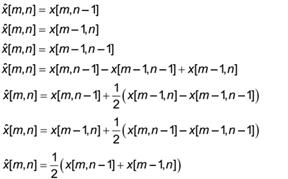
2. Εφαρμόστε στην εικόνα τους predictors χρησιμοποιώντας την cv2.filter2D, και προβάλετε την έξοδο κάθε predictor

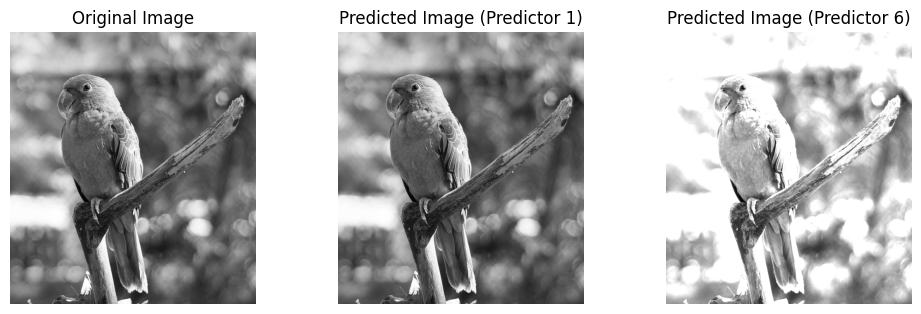

In [2]:
predictor1_mask = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
predictor2_mask = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
predictor3_mask = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
predictor4_mask = predictor1_mask - predictor3_mask + predictor2_mask
predictor5_mask = predictor1_mask + 0.5 * (predictor2_mask - predictor3_mask)
predictor6_mask = predictor2_mask + 0.5 * (predictor1_mask + predictor3_mask)
predictor7_mask = 0.5 * (predictor1_mask + predictor2_mask)


# Apply predictors as filters
predicted_image_1 = cv2.filter2D(image, -1, predictor1_mask)
predicted_image_2 = cv2.filter2D(image, -1, predictor2_mask)
predicted_image_3 = cv2.filter2D(image, -1, predictor3_mask)
predicted_image_4 = cv2.filter2D(image, -1, predictor4_mask)
predicted_image_5 = cv2.filter2D(image, -1, predictor5_mask)
predicted_image_6 = cv2.filter2D(image, -1, predictor6_mask)
predicted_image_7 = cv2.filter2D(image, -1, predictor7_mask)

# Display the original and predicted images
plt.figure(figsize=(12, 12))

plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(predicted_image_1, cmap='gray')
plt.title('Predicted Image (Predictor 1)')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(predicted_image_6, cmap='gray')
plt.title('Predicted Image (Predictor 6)')
plt.axis('off')

plt.show()

3. Για κάθε predictor υπολογίστε το σφάλμα, το ιστόγραμμα (με np.histogram) και την εντροπία του σφάλματος. Προβάλετε τα ιστογράμματα των σφαλμάτων. Ποιός predictor είναι καλύτερος για τη συμπίεση της εικόνας αυτής?

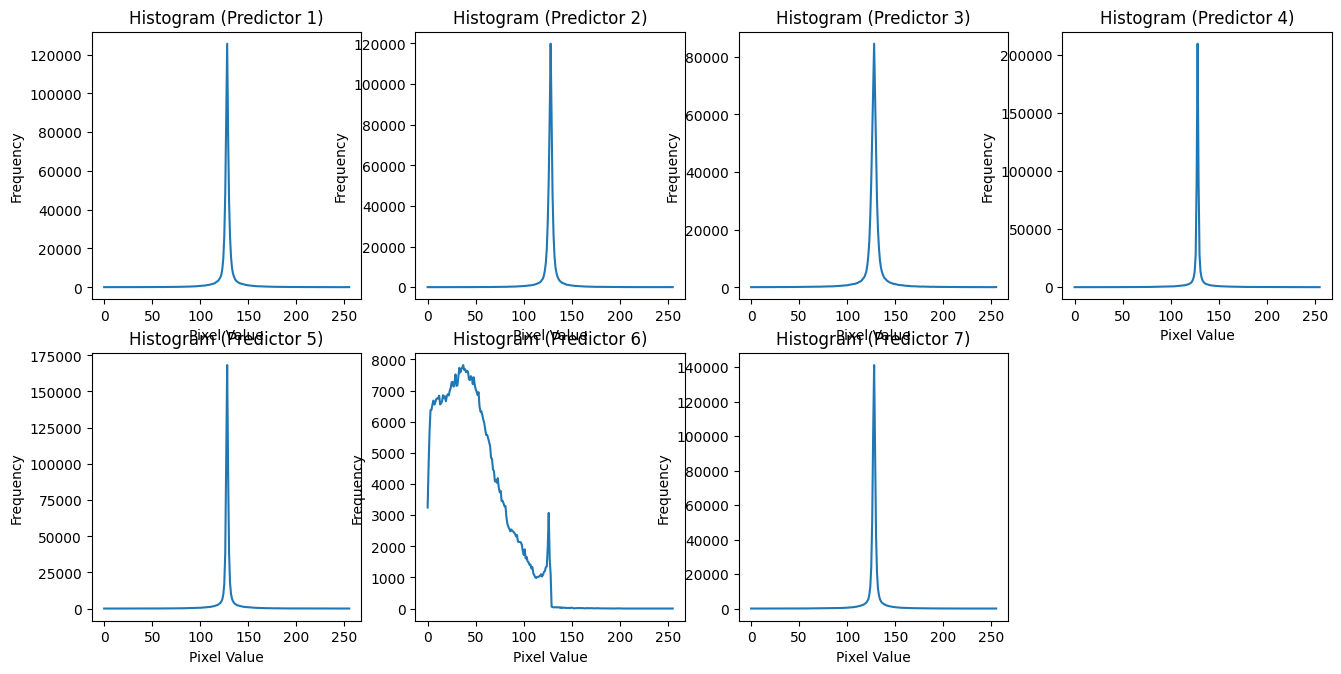

Entropy for Original image: 7.6507
Entropy for Predictor 1: 4.3709
Entropy for Predictor 2: 4.2901
Entropy for Predictor 3: 4.7265
Entropy for Predictor 4: 3.8236
Entropy for Predictor 5: 3.9665
Entropy for Predictor 6: 6.8027
Entropy for Predictor 7: 4.0337

Least entropy is entropy_4 = 3.8236269847527704


In [3]:
# Compute prediction errors for each predictor
prediction_error_1 = image.astype(int) - predicted_image_1.astype(int) # int ---> Epeidh einai unit8, gia na mhn kanei clip sto 0
prediction_error_2 = image.astype(int) - predicted_image_2.astype(int)
prediction_error_3 = image.astype(int) - predicted_image_3.astype(int)
prediction_error_4 = image.astype(int) - predicted_image_4.astype(int)
prediction_error_5 = image.astype(int) - predicted_image_5.astype(int)
prediction_error_6 = image.astype(int) - predicted_image_6.astype(int)
prediction_error_7 = image.astype(int) - predicted_image_7.astype(int)

# Compute histograms of prediction errors
histogram_original,_ = np.histogram(image.flatten(), bins=256, range=(0, 255))
histogram_1,_ = np.histogram(prediction_error_1.flatten(), bins=256, range=(-128, 128))
histogram_2,_ = np.histogram(prediction_error_2.flatten(), bins=256, range=(-128, 128))
histogram_3,_ = np.histogram(prediction_error_3.flatten(), bins=256, range=(-128, 128))
histogram_4,_ = np.histogram(prediction_error_4.flatten(), bins=256, range=(-128, 128))
histogram_5,_ = np.histogram(prediction_error_5.flatten(), bins=256, range=(-128, 128))
histogram_6,_ = np.histogram(prediction_error_6.flatten(), bins=256, range=(-128, 128))
histogram_7,_ = np.histogram(prediction_error_7.flatten(), bins=256, range=(-128, 128))

histograms = [
    histogram_1,
    histogram_2,
    histogram_3,
    histogram_4,
    histogram_5,
    histogram_6,
    histogram_7
]

plt.figure(figsize=(16, 16))
for i, histogram in enumerate(histograms, start=1):
    plt.subplot(4, 4, i)
    plt.plot(histogram)
    plt.title(f"Histogram (Predictor {i})")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.show()

def compute_entropy(histogram):
    histogram_normalized = histogram / histogram.sum()
    entropy_value = -np.sum(histogram_normalized * np.log2(histogram_normalized + 1e-10))
    return entropy_value

enrory_original=compute_entropy(histogram_original)
entropy_1 = compute_entropy(histogram_1)
entropy_2 = compute_entropy(histogram_2)
entropy_3 = compute_entropy(histogram_3)
entropy_4 = compute_entropy(histogram_4)
entropy_5 = compute_entropy(histogram_5)
entropy_6 = compute_entropy(histogram_6)
entropy_7 = compute_entropy(histogram_7)

print(f"Entropy for Original image: {enrory_original:.4f}")
print(f"Entropy for Predictor 1: {entropy_1:.4f}")
print(f"Entropy for Predictor 2: {entropy_2:.4f}")
print(f"Entropy for Predictor 3: {entropy_3:.4f}")
print(f"Entropy for Predictor 4: {entropy_4:.4f}")
print(f"Entropy for Predictor 5: {entropy_5:.4f}")
print(f"Entropy for Predictor 6: {entropy_6:.4f}")
print(f"Entropy for Predictor 7: {entropy_7:.4f}")

entropies = [
    entropy_1,
    entropy_2,
    entropy_3,
    entropy_4,
    entropy_5,
    entropy_6,
    entropy_7
]

min_entropy = min(entropies)
min_idx = entropies.index(min_entropy) + 1
print("")
print(f"Least entropy is entropy_{min_idx} = {min_entropy}")

**Συμπίεση JPEG με απώλειες**

1. Φορτώστε την εικόνα dog_square.png και χρησιμοποιώντας cv2.resize εκτελέστε κλιμάκωση της εικόνωας ώστε να έχει διαστάσεις 256x256.
2. Μετασχηματίστε την εικόνα σε χρωματικό χώρο YCbCr
3. Εκτελέστε υποδειγματοληψία στις χρωματικές συνιστώσες


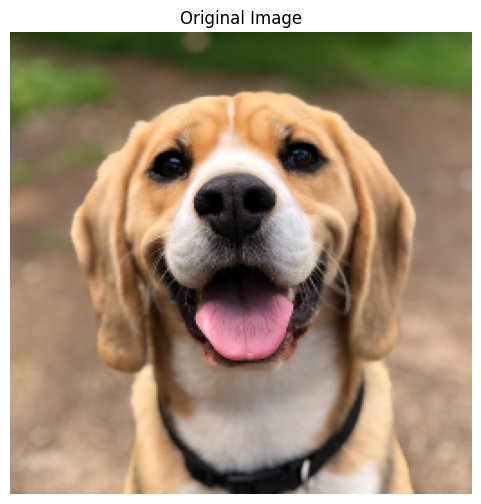

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request



image=cv2.imread('dog_square.png')
image = cv2.resize(image, (256, 256))
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
Y, cb, cr = cv2.split(ycbcr_image)
Cb_downsampled = cb[::2, ::2]
Cr_downsampled = cr[::2, ::2]


# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()


**2D-DCT Μετασχηματισμός και κβάντιση συντελεστών**

Εκτελέστε τον ακόλουθο κώδικα που πραγματοποιεί DCT μετασχηματισμό σε 8x8 blocks των καναλιών. Προβάλετε το σχήμα των εμεξεργασμένων καταλιών (Y_processed,...) . Επιλέξτε ένα DCT και προβάλετε το πριν και μετά την κβάντιση.



(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

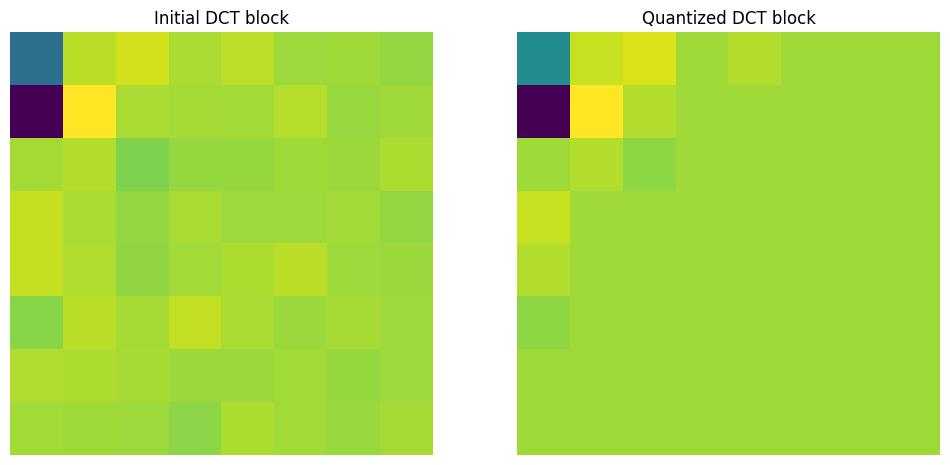

In [ ]:
# Function to compute the 2D DCT of an 8x8 block
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Quantization matrices for Y and CbCr channels
QY = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

QY_high = np.array([
    [8, 6, 5, 8, 12, 20, 26, 31],
    [6, 6, 7, 10, 13, 29, 30, 28],
    [7, 7, 8, 12, 20, 29, 35, 28],
    [7, 9, 12, 15, 26, 44, 40, 31],
    [9, 12, 19, 28, 34, 55, 52, 39],
    [12, 18, 28, 32, 40, 52, 56, 46],
    [25, 32, 39, 44, 52, 61, 60, 51],
    [36, 46, 48, 49, 56, 50, 52, 50]
])

QY_low = np.array([
    [32, 22, 20, 32, 48, 80, 102, 122],
    [24, 24, 28, 38, 52, 116, 120, 110],
    [28, 26, 32, 48, 80, 114, 138, 112],
    [28, 34, 44, 58, 102, 174, 160, 124],
    [36, 44, 74, 112, 136, 218, 206, 154],
    [48, 70, 110, 128, 162, 208, 226, 184],
    [98, 128, 156, 174, 206, 242, 240, 202],
    [144, 184, 190, 196, 224, 200, 206, 198]
])

QC = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

# Quantize DCT coefficients
def quantize(block, q_matrix):
    return np.round(block / q_matrix)


# Process each channel with block-wise DCT and quantization
def process_channel(channel, q_matrix):
    blocks = view_as_blocks(channel, block_shape=(8, 8))
    processed_blocks = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            block = blocks[i, j]
            dct_block = dct2(block - 128)
            quant_block = quantize(dct_block, q_matrix)
            processed_blocks[i, j] = quant_block
    return processed_blocks

Y_processed = process_channel(Y.astype(int), QY)
Cb_processed = process_channel(Cb_downsampled.astype(int), QC)
Cr_processed = process_channel(Cr_downsampled.astype(int), QC)

Y_blocks = view_as_blocks(Y.astype(int), block_shape=(8, 8))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dct2(Y_blocks[10, 10]-128))
plt.title('Initial DCT block')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Y_processed[10, 10])
plt.title('Quantized DCT block')
plt.axis('off')



**Κωδικοποίηση Εντροπίας των κβαντισμένων συντελεστών**

Εκτελέστε τον ακόλουθο κώδικα που υλοποιήσει συμπίεση Huffman στα κβαντισμένα DCT blocks.
1. Συμπληρώστε τον κώδικα ώστε να υπολογίσετε τον λόγο συμπίεσης που επιτυγχάνεται.
2. Προβάλετε και παρατηρείστε τους κώδικες Huffman που δημιουργούνται.

In [ ]:
# Huffman coding
class HuffmanNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.frequency + node2.frequency)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_codes(tree, prefix="", codebook={}):
    if tree.value is not None:
        codebook[tree.value] = prefix
    else:
        if tree.left:
            build_huffman_codes(tree.left, prefix + "0", codebook)
        if tree.right:
            build_huffman_codes(tree.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    frequencies = defaultdict(int)
    for item in data:
        frequencies[item] += 1
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = build_huffman_codes(huffman_tree)
    encoded_data = ''.join([huffman_codes[item] for item in data])
    return encoded_data, huffman_codes

# Zigzag order                            # Ξεδιπλωμα σειρας των block
zigzag_index = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

# Function to apply zigzag scan
def zigzag_scan(block):
    return block.flatten()[zigzag_index.flatten()]

# Encode processed Y channel using Huffman coding
#Y_flattened = Y_processed.flatten()
Y_zigzag = [zigzag_scan(block) for block in Y_processed.reshape(-1, 8, 8)]
Cb_zigzag = [zigzag_scan(block) for block in Cb_processed.reshape(-1, 8, 8)]
Cr_zigzag = [zigzag_scan(block) for block in Cr_processed.reshape(-1, 8, 8)]

Y_flattened = np.concatenate(Y_zigzag).astype(int)
Cb_flattened = np.concatenate(Cb_zigzag).astype(int)
Cr_flattened = np.concatenate(Cr_zigzag).astype(int)

encoded_Y, huffman_codes_Y = huffman_encode(Y_flattened)
encoded_Cb, huffman_codes_Cb = huffman_encode(Cb_flattened)
encoded_Cr, huffman_codes_Cr = huffman_encode(Cr_flattened)

encoded_bit_stream = encoded_Y + encoded_Cb + encoded_Cr    # Πρεπει να αφαιρεσουμε τους DC συντελεστες διοτι ακολουθουν διαφορετικη διαδικασια

# Display the first 100 bits of the final bit stream for brevity
print(f"Encoded Bit Stream (first 100 bits): {encoded_bit_stream[:100]}")

# Calculate compression ratio
original_size = 256*256*3
compressed_size = len(encoded_bit_stream)
compression_ratio = compressed_size / original_size

print(f"Compression Ratio: {compression_ratio:.2f}")
print(huffman_codes_Y)


                                      # Στο compressed size συμπεριλαμβανουμε και τα bits για το καθε συμβολο



Encoded Bit Stream (first 100 bits): 0111110011001100111111111111111001110111111101011111111111111111111111111111111111111100100111000011
Compression Ratio: 0.69
{np.int64(1): '001', np.int64(14): '01110001', np.int64(-30): '0010000010', np.int64(35): '0010000011', np.int64(8): '01010', np.int64(-26): '0010001000', np.int64(-20): '0000100101', np.int64(-17): '000010001', np.int64(11): '0111111', np.int64(-11): '000110', np.int64(50): '001001001000', np.int64(-60): '001001001001', np.int64(40): '00100100101', np.int64(41): '00100100110', np.int64(-56): '001001001110', np.int64(-55): '001001001111', np.int64(-10): '0111100', np.int64(10): '010010', np.int64(-36): '00100111000', np.int64(-58): '001001110010', np.int64(-42): '001001110011', np.int64(-43): '001001110100', np.int64(45): '001001110101', np.int64(-51): '00100111011', np.int64(-25): '0010011110', np.int64(28): '0010011111', np.int64(6): '0111001', np.int64(-6): '0111001', np.int64(-8): '00010', np.int64(9): '011110', np.int64(-

Εκτελέστε τον ακόλουθο κώδικα ώστε να οπτικοποιήσετε χωρικά τους συντελεστές DCT

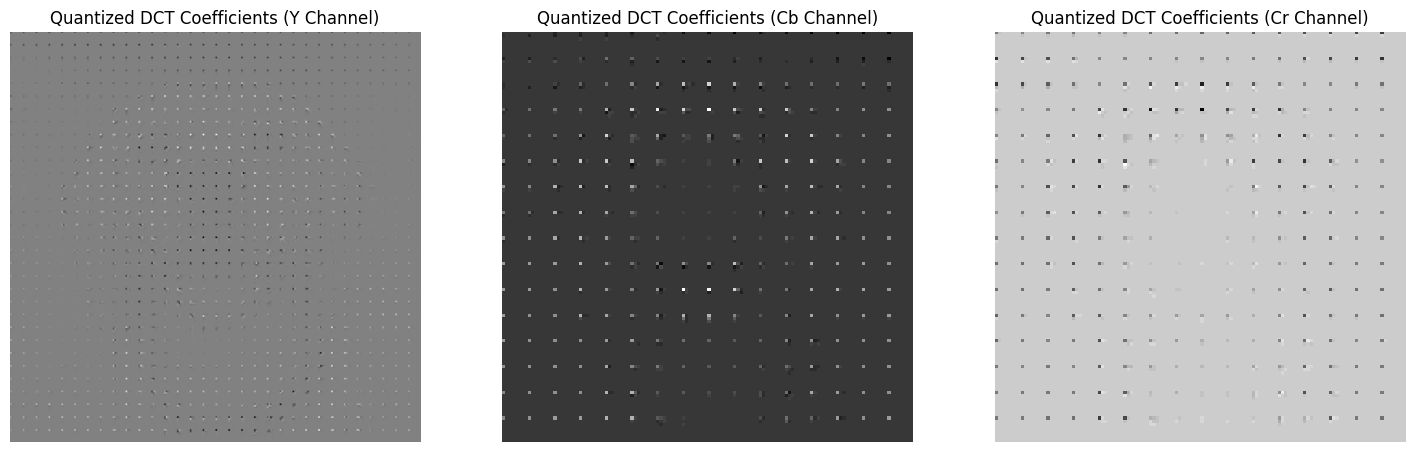

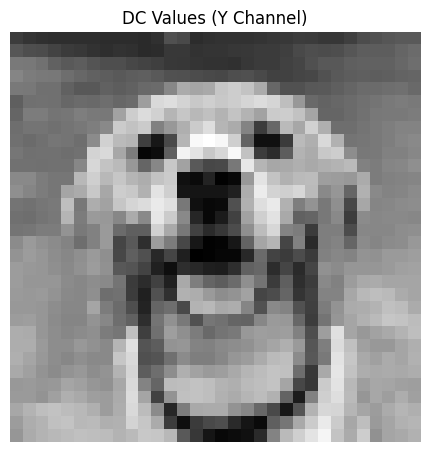

In [ ]:

# Visualize the quantized DCT coefficients of Y channel
def visualize_quantized_dct(processed_blocks):
    reconstructed_image = np.zeros((processed_blocks.shape[0] * 8, processed_blocks.shape[1] * 8))
    for i in range(processed_blocks.shape[0]):
        for j in range(processed_blocks.shape[1]):
            block = processed_blocks[i, j]
            for m in range(8):
                for n in range(8):
                    reconstructed_image[i * 8 + m, j * 8 + n] = block[m, n]
    return reconstructed_image

visualized_dct_Y = visualize_quantized_dct(Y_processed)
visualized_dct_Cb= visualize_quantized_dct(Cb_processed)
visualized_dct_Cr = visualize_quantized_dct(Cr_processed)



plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(visualized_dct_Y, cmap='gray')
plt.title('Quantized DCT Coefficients (Y Channel)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualized_dct_Cb, cmap='gray')
plt.title('Quantized DCT Coefficients (Cb Channel)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualized_dct_Cr, cmap='gray')
plt.title('Quantized DCT Coefficients (Cr Channel)')
plt.axis('off')
plt.show()

flatten_blocks = Y_processed.reshape(Y_processed.shape[0], Y_processed.shape[1], -1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(flatten_blocks[:,:,0], cmap='gray')
plt.title('DC Values (Y Channel)')
plt.axis('off')
plt.show()

